# Load Libraries

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import neurokit2 as nk
import warnings
import ecg_plot
import glob

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

from scipy import interp
from mpl_toolkits.mplot3d import axes3d

# Feature Engineering

In this section I process the ecg recordings (from normal and type 1 LQT) and extract the QT interval and RR interval.

Each record has 12 ecgs with duration of 10 sec:

1) data is filtered <br>
2) baseline wandering from the time serie removed <br>
3) R peaks are detected using wavelet peak detection <br>
4) from each ecg a number of reliable beats are extracted using cross-correlation <br>
5) The mean and standard deviation of of QT and RR intervals are exported to a dataframe and also saved in excel files. <br>

instead of calling extract function every time, I stored them in an excell file and load the excel<br>


Note: To re-calculate features again run this code: <br>

Extract features for normal<br>
mylist = [f for f in glob.glob("C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/Unaffected_csv/*.csv")]<br>
df1 = extract_QT_RT(mylist)<br>

Extract features for Type 1. For Type2 change name of the file<br>
mylist = [f for f in glob.glob("C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/Type1_csv/*.csv")]<br>
df2 = extract_QT_RT(mylist)<br>

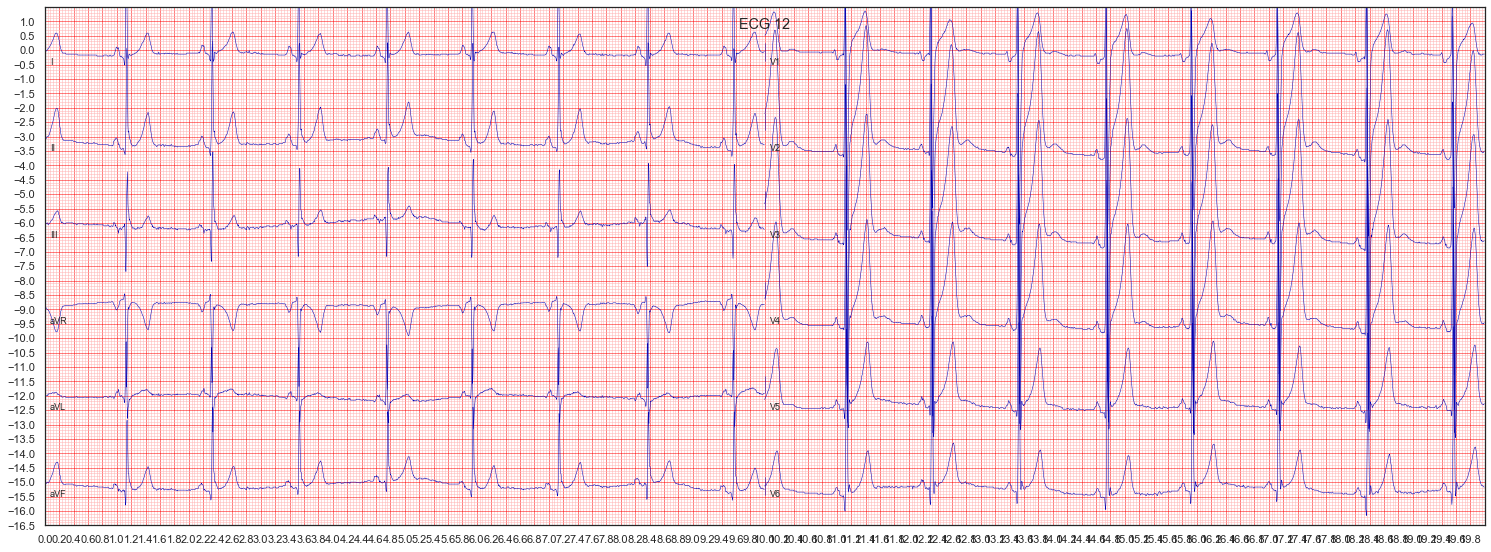

In [657]:
# show a sample 12 lead ECG
sample_12_lead_ecg()

# Load Data

In this section the following tasks are done:

1) read features from excel file for Type1, Type2 and Normal <br>
2) add the target column "LQT": 1 for Type1 and Type2   and 0 for Normal <br>
3) combine all in 1 data frame df1 <br>
4) add patient demographics where possible<br>

In [20]:
# Type 1 (read, and add target = 1)
df1 = pd.read_excel('C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/Type1R.xlsx')
df1['LQT'] = np.ones((df1.shape[0], 1)) 

# Type 2 (read, and add target = 1)
df2 = pd.read_excel('C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/Type2R.xlsx')
df2['LQT'] = np.ones((df2.shape[0], 1)) 

# Normal (read, and add target = 0)
dfn = pd.read_excel('C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/UnaffectedR.xlsx')
dfn['LQT'] = np.zeros((dfn.shape[0], 1))

# Combine type1 , type 2, and normal in 1 dataframe
df1 = df1.append([df2,dfn],ignore_index = True)

# get the patient demographics
df3 = pd.read_excel('C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/LQTS_demographics.xlsx')

# add demographic data of the subjects (age, sex, ethnicity) where the subject is found in df1
df1 = pd.merge(df1, df3, on='subject', how='left')

In [72]:
df1.head()

,Unnamed: 0,subject,# V2,mQT V2,sQT V2,#Rpeaks,mRR,sRR,LQT,sex,dob,ethnicity,age,eth_dummy,sex_dummy,QTc_Fram
0,0,3068,5.0,112.000000,11.506520,11,194.454545,2.995865,1.0,Female,1950-05-15,White/Caucasian,70,0,0,-0.008916
1,1,3093,10.0,110.222222,46.661375,14,164.500000,13.334970,1.0,Female,2012-04-15,Aboriginal,8,1,0,-0.010382
2,2,3094,10.0,110.222222,46.661375,14,164.500000,13.334970,1.0,Male,1978-05-15,Aboriginal,42,1,1,-0.010382
3,3,3095,8.0,113.000000,6.676184,8,265.125000,2.521780,1.0,Female,1952-12-15,White/Caucasian,68,0,0,-0.006589
4,4,3108,12.0,120.090909,1.880742,11,199.090909,6.215151,1.0,Female,1982-08-15,Aboriginal,38,1,0,-0.009336


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 45 columns):
Unnamed: 0    187 non-null int64
subject       187 non-null int64
#I            158 non-null float64
mQTI          158 non-null float64
sQTI          158 non-null float64
# II          161 non-null float64
mQT II        161 non-null float64
sQT II        161 non-null float64
# III         148 non-null float64
mQT III       148 non-null float64
sQT III       148 non-null float64
# aVR         102 non-null float64
mQT aVR       102 non-null float64
sQT aVR       102 non-null float64
# aVL         162 non-null float64
mQT aVL       162 non-null float64
sQT aVL       162 non-null float64
# aVF         157 non-null float64
mQT aVF       157 non-null float64
sQT aVF       157 non-null float64
# V1          144 non-null float64
mQT V1        144 non-null float64
sQT V1        144 non-null float64
# V2          163 non-null float64
mQT V2        163 non-null float64
sQT V2        163 non-nu

# Data Wrangling

In this section I will do the following:


1) convert dob to age<br>
2) regroup some ethnicities and create dummy variable<br>
3) create dummy variable for sex: 0 for female and 1 for male<br>
4) find and replace the ? with nan <br>
5) find the number of missing data for each column<br>
6) remove columns with more than 20 missing values<br>
7) for the remaining columns fill the missing values with the average of that column<br>
8) add a new feature by combining 2 of the existing features<br>

In [22]:
# convert dob to age
df1['age'] = pd.to_datetime('today').year-pd.to_datetime(df1.dob.values.tolist()).year

In [23]:
# check the ethnicity unique entries to combine and create dummies
df1[['LQT','ethnicity']].groupby('ethnicity').count()

,LQT
ethnicity,
0,1
Aboriginal,16
Aboriginal,2
Arab/West Asian,3
Arab/West Asian,1
Chinese,13
Filipino,2
Japanese,5
Korean,1


In [24]:
# combine ethnicity and create dummy variable 'eth_dummy': 
eth_white = df1['ethnicity'].unique()[[0,3,9,14]]
eth_aborig = df1['ethnicity'].unique()[[1,8]]
eth_asian = df1['ethnicity'].unique()[[2,4,6,10,11,12]]

def parse_values(x):
    if x in eth_white:
       return 0
    elif x in eth_aborig:
       return 1
    elif x in eth_asian:
       return 2
    else:
       return 3

df1['eth_dummy'] = df1['ethnicity'].apply(parse_values)

In [25]:
# create dummy variable for sex: 'sex_dummy'
df1['sex_dummy'] = df1['sex'].apply(lambda x: 0 if x == 'Female' else 1)
df1.head()

,Unnamed: 0,subject,#I,mQTI,sQTI,# II,mQT II,sQT II,# III,mQT III,...,#Rpeaks,mRR,sRR,LQT,sex,dob,ethnicity,age,eth_dummy,sex_dummy
0,0,3068,7.0,102.142857,2.099563,2.0,102.500000,0.500000,NaN,NaN,...,11,194.454545,2.995865,1.0,Female,1950-05-15,White/Caucasian,70,0,0
1,1,3093,3.0,88.666667,4.109609,1.0,83.000000,0.000000,1.0,79.000000,...,14,164.500000,13.334970,1.0,Female,2012-04-15,Aboriginal,8,1,0
2,2,3094,3.0,88.666667,4.109609,1.0,83.000000,0.000000,1.0,79.000000,...,14,164.500000,13.334970,1.0,Male,1978-05-15,Aboriginal,42,1,1
3,3,3095,9.0,103.750000,0.968246,9.0,103.625000,0.695971,9.0,103.875000,...,8,265.125000,2.521780,1.0,Female,1952-12-15,White/Caucasian,68,0,0
4,4,3108,12.0,96.636364,0.771389,12.0,99.181818,1.028519,12.0,99.454545,...,11,199.090909,6.215151,1.0,Female,1982-08-15,Aboriginal,38,1,0


In [26]:
# replace "?" to NaN
df1.replace('?', np.nan, inplace = True)

# find counts  of missing data for each column
print(df1.isnull().sum())

Unnamed: 0     0
subject        0
#I            29
mQTI          29
sQTI          29
# II          26
mQT II        26
sQT II        26
# III         39
mQT III       39
sQT III       39
# aVR         85
mQT aVR       85
sQT aVR       85
# aVL         25
mQT aVL       25
sQT aVL       25
# aVF         30
mQT aVF       30
sQT aVF       30
# V1          43
mQT V1        43
sQT V1        43
# V2          24
mQT V2        24
sQT V2        24
# V3          37
mQT V3        37
sQT V3        37
# V4          30
mQT V4        31
sQT V4        31
# V5          40
mQT V5        40
sQT V5        40
# V6          38
mQT V6        38
sQT V6        38
#Rpeaks        0
mRR            0
sRR            0
LQT            0
sex            0
dob            0
ethnicity      0
age            0
eth_dummy      0
sex_dummy      0
dtype: int64


In [27]:
# remove columns with equal or more than 25 missing values
for column in df1.columns:
    if df1.isnull().sum()[column] >= 25:
        df1 = df1.drop(column, axis = 1)

In [30]:
# fill the missing values of the remaining columns with their averages
df1 = df1.fillna(df1.groupby('LQT').transform('mean'))

In [31]:
# generate a new feature QT corrected Framingham: 'QTc_Fram'
df1['QTc_Fram'] = .0154 * df1['mQT V2'] / (1 - df1['mRR'])
df1.head()

,Unnamed: 0,subject,# V2,mQT V2,sQT V2,#Rpeaks,mRR,sRR,LQT,sex,dob,ethnicity,age,eth_dummy,sex_dummy,QTc_Fram
0,0,3068,5.0,112.000000,11.506520,11,194.454545,2.995865,1.0,Female,1950-05-15,White/Caucasian,70,0,0,-0.008916
1,1,3093,10.0,110.222222,46.661375,14,164.500000,13.334970,1.0,Female,2012-04-15,Aboriginal,8,1,0,-0.010382
2,2,3094,10.0,110.222222,46.661375,14,164.500000,13.334970,1.0,Male,1978-05-15,Aboriginal,42,1,1,-0.010382
3,3,3095,8.0,113.000000,6.676184,8,265.125000,2.521780,1.0,Female,1952-12-15,White/Caucasian,68,0,0,-0.006589
4,4,3108,12.0,120.090909,1.880742,11,199.090909,6.215151,1.0,Female,1982-08-15,Aboriginal,38,1,0,-0.009336


# Explore

1) take a look how the main feature space looks like<br>
2) do some descriptive statistics<br>
3) prepare the X and Y pairs for ML<br>
4) check the distribution of the data<br>
5) standardize/normalize the data

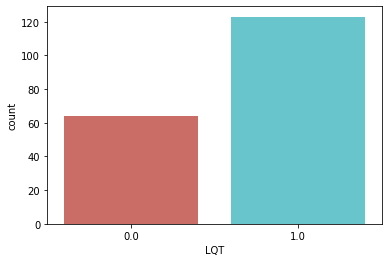

In [32]:
# number of subjects in each class
sns.countplot(x = 'LQT', data = df1, palette = 'hls')

Text(0.5, 0, 'mQT V2')

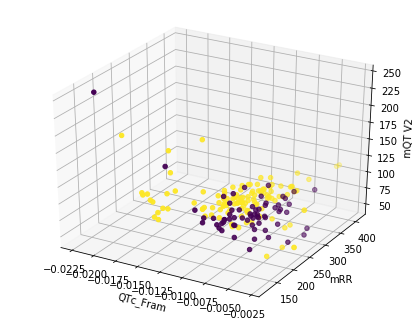

In [71]:
# A taste of feature sub-space: yellow = Type1Type2, Purple = normal
fig = plt.figure(figsize = (16, 12.5))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
a = ax.scatter(X['QTc_Fram'], X['mRR'], X['mQT V2'], c = Y.values)

#plt.plot(a)
ax.set_xlabel('QTc_Fram')
ax.set_ylabel('mRR')
ax.set_zlabel('mQT V2')

In [34]:
# calc mean of the features
df1.groupby('LQT').mean()

,Unnamed: 0,subject,# V2,mQT V2,sQT V2,#Rpeaks,mRR,sRR,age,eth_dummy,sex_dummy,QTc_Fram
LQT,,,,,,,,,,,,
0.0,31.500000,5259.734375,10.456140,96.328075,9.140901,11.453125,215.317277,13.166184,46.656250,1.937500,0.531250,-0.007226
1.0,34.739837,6408.569106,9.867925,110.338629,9.722933,10.878049,220.769138,17.957908,47.796748,0.463415,0.308943,-0.008280


In [58]:
# prep input (X) and output (Y) for ML
Y = df1['LQT']
X = df1.drop(['Unnamed: 0','subject','# V2','#Rpeaks','LQT', 'dob', 'sex', 'ethnicity'], axis = 1)
#X = X.drop(['sQT V2', 'sRR'], axis = 1)
X.head()

,mQT V2,sQT V2,mRR,sRR,age,eth_dummy,sex_dummy,QTc_Fram
0,112.000000,11.506520,194.454545,2.995865,70,0,0,-0.008916
1,110.222222,46.661375,164.500000,13.334970,8,1,0,-0.010382
2,110.222222,46.661375,164.500000,13.334970,42,1,1,-0.010382
3,113.000000,6.676184,265.125000,2.521780,68,0,0,-0.006589
4,120.090909,1.880742,199.090909,6.215151,38,1,0,-0.009336


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000229D76AE748>,
      dtype=object)

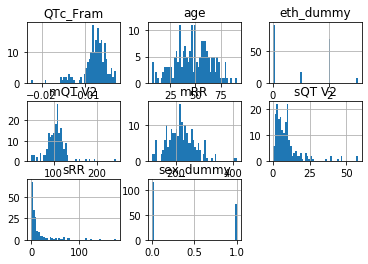

In [59]:
X.hist(bins=50)

In [52]:
# Scale the data to be between -1 and 1
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X=scaler.fit_transform(X)

# ML Model Comparision

I want to have a quick look at different classifiers to see which one will have a better performance on accuracy <br>
Then select the 2 best models and tune hyper parameters

1) Logistic Regression<br>
2) Linear Discriminant Analysis<br>
3) K Nearest Neighbor<br>
4) Descision Tree<br>
5) Naive Bayes<br>
6) Support Vector Machine<br>

In [60]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma = 'auto')))

In [61]:
# evaluate each model's accuracy report mean and standard deviation for cross validation 
results = []
names = []
scoring = 'accuracy'
warnings.filterwarnings('ignore')

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state= seed)
    cv_results = model_selection.cross_val_score(model, X, Y, 
                                                 cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.838596 (0.094665)
LDA: 0.871930 (0.071369)
KNN: 0.597953 (0.271924)
CART: 0.897661 (0.061612)
NB: 0.871345 (0.077483)
SVM: 0.642105 (0.447090)


[Text(0, 0, 'LR'),
 Text(0, 0, 'LDA'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'SVM')]

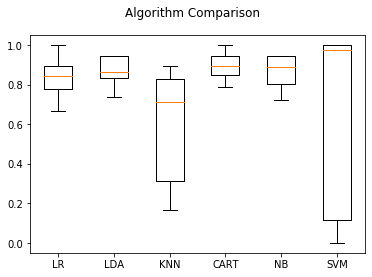

In [62]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

# Improve The Model

The model with the best performances is Descition Tree.<br>

1) I tried to reduce the colinearity by removing some non effective features: ['sQT V2', 'sRR', 'mQT V2', 'age']<br>
This bumped up the Logistic regression results to 88% and KNN to 78% still far from DT.<br>
2) To aviod overfitting instead of DT I used random forest ensembling<br>
3) I did hyper paratemer search do tune the parameters on validation data.<br>
4) print confusion matrix<br>
5) plot ROC curve

In [55]:
logit_model = sm.Logit(Y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.309708
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.518     
Dependent Variable: LQT              AIC:              131.8307  
Date:               2020-08-11 16:51 BIC:              157.6795  
No. Observations:   187              Log-Likelihood:   -57.915   
Df Model:           7                LL-Null:          -120.15   
Df Residuals:       179              LLR p-value:      8.9701e-24
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                Coef.   Std.Err.    z    P>|z|    [0.025   0.975]
-----------------------------------------------------------------
mQT V2          -0.0122   0.0298 -0.4095 0.6821   -0.0706  0.0462
sQT V2          -0.0096   0.0268 -0.3597 0.7190   -0.0621  0.0429


In [63]:
# hyper parameter search for random forest
rfc = RandomForestClassifier(random_state = 42)
grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' : ['gini', 'entropy']
}
rfc_cv = GridSearchCV(rfc, grid, cv = 10)
rfc_cv.fit(X, Y)

print("RandomForest :(best parameters) ", rfc_cv.best_params_)
print("accuracy :", rfc_cv.best_score_)

RandomForest :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}
accuracy : 0.9411764705882353


In [64]:
# evaluate the best model using the tuned parameters

rfc = RandomForestClassifier(criterion = 'gini', max_depth = 4, 
                             max_features = 'log2', n_estimators = 100, random_state = 42)
predicted = cross_val_predict(rfc, X, Y, cv = 10)

print (metrics.accuracy_score(Y, predicted))
print (metrics.classification_report(Y, predicted)) 

0.9411764705882353
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91        64
         1.0       0.95      0.96      0.96       123

    accuracy                           0.94       187
   macro avg       0.94      0.93      0.93       187
weighted avg       0.94      0.94      0.94       187



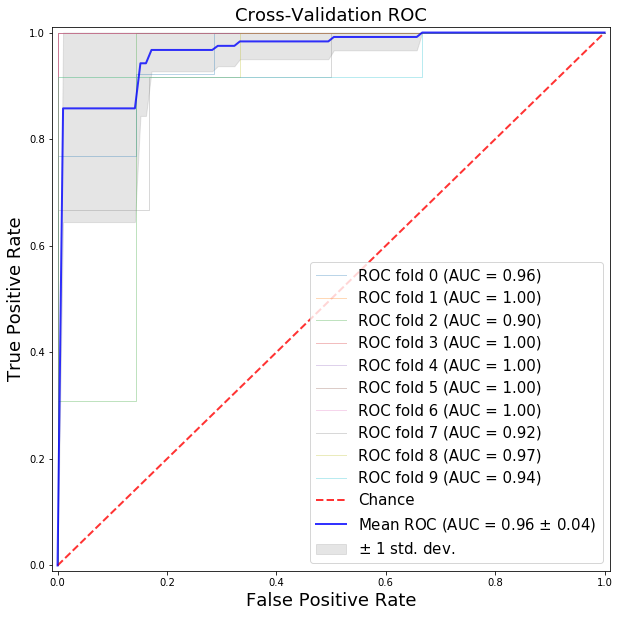

In [69]:
# Plot ROC curve 
plot_roc(X,Y, rfc, 10)

# Helper Functions

In [65]:
def plot_roc(X, Y, classifier, n_splits):
    X = X.values
    Y = Y.values
    classifier = classifier
    
    cv = StratifiedKFold(n_splits=10)
    #classifier = rfc#SVC(kernel='sigmoid',probability=True,random_state=0)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 0
    for train, test in cv.split(X, Y):
        probas_ = classifier.fit(X[train], Y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
    plt.show()


In [ ]:
def extract_QT_RT(mylist):
    
    """
    read all ecg recordings with *.csv format in a folder. extract QT and RR intervals and export to an excel file
    for each file: 12 lead of 10 sec recordings. number of selected beats, mean and standard deviation of QT and RR for each lead
    
    Parameters
    ----------
    mylist : is the address of the folder containing the files
    
    Outputs
    --------
    df : a pandas dataframe each row represent a file (subject). the features are in columns 
    """

    QT_all = []
    RT_all = []
    # iterate through all the files in the folder
    for j in range(len(mylist)):
        print('subject', j, ' out of ', len(mylist))
        # extract the name for ploting purposes
        subject = mylist[j][-8:-4]
        df = pd.read_csv(mylist[j])
        QT = dict()
        RT = dict()
        T_se = []
        QT['subject'] = subject
        RT['subject'] = subject

        # iterate through all 12 leads
        for i in range(12):
            try:
                lead_name = df.columns[i]
                ecg_signal = df[lead_name]
                # process ecg of the lead. 
                signals, info = nk.ecg_process(ecg_signal, sampling_rate = 250)
                cleaned_ecg = signals['ECG_Clean']
                rpeaks = info["ECG_R_Peaks"]
                # find the beats with good similarity 
                selected_beats = select_heart_beats(cleaned_ecg, rpeaks, similarity_coef, 250)
                # get the QT features
                QT_lead, TS, TE = calc_QT(lead_name,ecg_signal, rpeaks, selected_beats)
                QT.update(QT_lead)
                T_se.append([TS,TE])
            except:
                QT.update(dict(zip(['#' + lead_name, 'mQT' + lead_name, 'sQT' + lead_name], 
                                   [np.nan, np.nan, np.nan])))
        # sanity check the size of the TSE 
        if np.array(T_se).shape[0] > 1:
            Ts, Te = selMinMax(np.array(T_se)[:,0], np.array(T_se)[:, 1])
        elif np.array(T_se).shape[0] == 1:
            Ts = TS
            Te = TE
        else:
            Ts = np.nan
            Te = np.nan
            
        RT.update(dict(zip(['Rpeaks', 'Tstart', 'Tend'],
                           [rpeaks, Ts, Te])))
        QT.update(dict(zip(['#Rpeaks', 'mRR', 'sRR'], 
                           [len(np.diff(rpeaks)), np.diff(rpeaks).mean(), np.diff(rpeaks).std()])))
        QT_all.append(QT)
        RT_all.append(RT)
    
    df2 = pd.DataFrame(QT_all) 
    df3 = pd.DataFrame(RT_all)
    return df2

In [ ]:
def select_heart_beats(
        cleaned_ecg,rpeaks, similarity_coef, 
        sampling_rate):
    
    """
    Calculate the pearson correlation between beats recorded in an ecg lead. Compare with a set threshold of .7 similarity.
    # create and array of the same size of rpeaks. Turn on (set to 1) those beats with similarity >= .7
    # Turn of (set to 0) those with similarity less than .7
    
    Parameters
    ----------
    cleaned_ecg : filtered baseline wandering removed ecg. from the function process ecg.
    rpeaks : np.array of QRS peaks index. comes from ecg_process
    similarity_coef: threshold for similarity check. default to .7
    sampling rate: of the ecg recording. default = 250
    
    Outputs
    --------
    selected_beats : is a list of same size as rpeaks. 1 for selected peaks. 0 for non selected 
    """
    # process ecg => filtered and rpeaks
    heartbeats = nk.epochs_create(cleaned_ecg, events = rpeaks, epochs_start = -0.4, 
                                  epochs_end = 0.6, sampling_rate = sampling_rate)
    # convert the seperated beats into a dataframe. beats will be in columns
    heartbeats = nk.epochs_to_df(heartbeats)
    heartbeats_pivoted = heartbeats.pivot(index = 'Time', 
                                          columns = 'Label', values = 'Signal')
    # calc pearson corr
    heart_beat_corr = heartbeats_pivoted.corr(method = 'pearson')
    # turn on those who pass similarity
    heart_beat_corr = heart_beat_corr > similarity_coef
    # create a list 
    heart_beat_corr = heart_beat_corr.sum()
    selected_beats_idx = np.where(heart_beat_corr == np.max(heart_beat_corr.values))
    selected_beats_idx = np.array(selected_beats_idx).tolist()    
    selected_beats = heartbeats_pivoted[list(map(str,np.array(selected_beats_idx[0]) + 1))]
    selected_beats = np.zeros(len(rpeaks))
    selected_beats_idx = np.array(selected_beats_idx) - 1
    selected_beats[tuple(selected_beats_idx)] = 1
    return selected_beats

In [ ]:
def selMinMax(TS,TE):
    
    """
    Calculate the min distance of Twave start to Rpeaks and the max distance of Twave end to rpeaks
    It first checks for any outliers and removes them. It consideres distances more than 5 std as outlier
    Parameters
    ----------
    TS : Is the list of distances of the start of T waves from R peaks among all selected beats in 1 lead
    TE : Is the lsit of distance of the end of T waves from R peaks among all selected beats in 1 lead
    
    Outputs
    --------
    TS : Is the minimum distance of the start of T waves from R peaks among all selected beats in 1 lead
    TE : Is the maximum distance of the end of T waves from R peaks among all selected beats in 1 lead
    note: TS and TE along with Rpeaks will be exportef to extract Twave for future morphological analysis
    """
    # define and remove outliers for TS
    outlier = np.abs(TS - TS.mean()) < 5 * TS.std()
    outlier = outlier * 1
    TS = TS[outlier > 0]

    # define and remove outliers for TE
    outlier = np.abs(TE - TE.mean()) < 5 * TE.std()
    outlier = outlier * 1
    TE = TE[outlier > 0]
    
    TS = TS.min()
    TE = TE.max()
    return TS,TE

In [ ]:
def calc_QT(lead_name, ecg_signal, rpeaks, selected_beats):

    """
    Calculate mean and standard deviation QT interval for 1 ecg recording (1 lead)

    Parameters
    ----------
    lead_name : string. is the name of the lead being processed\
    
    ecg_signal: a np.array time serie of the ecg recording in mV
        Title for the chart.

    rpeaks : np array. index of rpeaks 
        
    selected_beats : np.array. index of QRSpeaks that have pass the similarity test.
        This is given by the output of the function select_heart_beats.
    
    Outputs
    --------
    QT_lead : Is a dictionary containing number of selected beats, their mean and std QT interval
    TS : Is the minimum distance of the start of T waves from R peaks among all selected beats in 1 lead
    TE : Is the maximum distance of the end of T waves from R peaks among all selected beats in 1 lead
    
    note: TS and TE along with Rpeaks will be exportef to extract Twave for future morphological analysis
    """
    # delineate the signal using derivative method to find Q peaks
    signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate = 250, 
                                             show = False, show_type = 'all')
    Q_peak = waves_dwt['ECG_Q_Peaks']
    
    # delineate the signal using wavelet method to find T start and T end
    signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate = 250, 
                                             method = 'dwt', show = False, show_type = 'bounds_T')
    T_end = waves_dwt['ECG_T_Offsets']
    T_str = waves_dwt['ECG_T_Onsets']
    
    # calculate the distance of start and end of Twave from R peaks
    T_str = T_str - rpeaks[:len(T_str)]
    T_end = T_end - rpeaks[:len(T_end)]
    
    # find the min distance of start T from R and max distance of end T from R
    TS, TE = selMinMax(T_str, T_end)
    
    # make sure the last T wave (start and end) was captured in recording. If not omit. 
    # If numbers mismatch return error 
    if len(Q_peak) - len(T_end) == 0:
        QT_int = np.array(T_end) - np.array(Q_peak)
    elif len(Q_peak) - len(T_end) == 1:
        QT_int = np.array(T_end) - np.array(Q_peak[:-1])
        QT_int = np.append(QT_int, 0)
    else:
        print(lead_name,': something is fishy here')
    
    # narrow list of QT interval to those previously selected by similarity test
    QT_int_select = QT_int[selected_beats == 1]
    if QT_int_select[-1] == 0:
        QT_int_select = QT_int_select[:-1]
    
    # create a dictionary with keys: #, mQT, sQT
    QT_lead = dict(zip(['#' + lead_name, 'mQT' + lead_name, 'sQT' + lead_name,], 
                       [selected_beats.sum(), QT_int_select.mean(), QT_int_select.std()]))
    return QT_lead, TS, TE

In [656]:
def sample_12_lead_ecg():

    """
    Generate a sample 12 lead ECG plot that looks like a paper ECG: Suject 3140 will be plotted.
    requires ecg_plot library
    """
    df_sample = pd.read_csv('C:/Users/javad/Documents/QUEENS/DATA from Brianna/XML ECG v2/Type1_csv\\3140.csv')
    ecg_array = df_sample.to_numpy()[:, :-1].T / 280
    ecg_plot.plot(ecg_array, sample_rate = 250, title = 'ECG 12')
    ecg_plot.show()

In [ ]:
def plot_learning_curve(
        estimator, title, X, y, axes = None, ylim = None, cv = None, n_jobs = None, 
        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)#,
                       #return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt